In [1]:
import gpt_prompt
import os
import json
import requests
import time
import re
import numpy as np
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
import threading
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mj_api_key = os.getenv('MJ_API_KEY')

In [3]:
def imagine(prompt):
    headers = {
    'Authorization': f'Bearer {mj_api_key}',
    'Content-Type': 'application/json'
    }

    url = "https://api.thenextleg.io/v2/imagine"

    payload_image = json.dumps({
    "msg": prompt,
    "ref": "",
    "webhookOverride": "", 
    "ignorePrefilter": "false"
    })

    def check_task_status(url):
        while True:
            response_result = requests.request("GET", url, headers=headers)
            if response_result.status_code == 200:
                json_response = json.loads(response_result.text)
                progress = json_response['progress']
                if progress == 100:
                    return json_response["response"]['imageUrl'], json_response["response"]['imageUrls']
            else:
                print(f"Request failed, status code: {response_result.status_code}")
            time.sleep(3)

    attempts = 0
    max_attempts = 3
    while attempts <= max_attempts:
        time.sleep(1)
        messageId = None
        response_image = requests.request("POST", url, headers=headers, data=payload_image)
        if response_image.status_code == 200:
            messageId = response_image.json().get('messageId')

        url_with_id = f"https://api.thenextleg.io/v2/message/{messageId}?expireMins=2"
        
        if messageId:
            img_url, img_urls = check_task_status(url_with_id)
            if img_url is not None and img_url != '':
                return img_url, img_urls
            else:
                attempts += 1
    raise ValueError("Unable to get valid image URL after multiple attempts")


In [4]:
def describe(image_url):
    url = "https://api.thenextleg.io/v2/describe"
    payload = json.dumps({
    "url": image_url,
    "ref": "",
    "webhookOverride": ""
    })
    headers = {
    'Authorization': f'Bearer {mj_api_key}',
    'Content-Type': 'application/json'
    }

    def check_task_status(url):
        while True:
            response_result = requests.request("GET", url, headers=headers)
            if response_result.status_code == 200:
                json_response = json.loads(response_result.text)
                progress = json_response['progress']
                if progress == 100:
                    return json_response["response"]['content']
            else:
                print(f"Request failed, status code: {response_result.status_code}")
            time.sleep(2)

    attempts = 0
    max_attempts = 3
    while attempts <= max_attempts:
        time.sleep(1)
        messageId = None
        response_image = requests.request("POST", url, headers=headers, data=payload)
        if response_image.status_code == 200 and response_image.json().get('success') == True:
            messageId = response_image.json().get('messageId')

        url_with_id = f"https://api.thenextleg.io/v2/message/{messageId}?expireMins=2"
        
        if messageId:
            texts = check_task_status(url_with_id)
            if texts is not None and texts != '':
                cleaned_texts = [re.sub(r'\[(.*?)\]', r'\1', item) for item in texts]
                cleaned_texts = [re.sub(r'\(.*?\)', '', item) for item in cleaned_texts]
                cleaned_texts = [re.sub(r',\s*,', ',', item).strip() for item in cleaned_texts]

                return cleaned_texts
            else:
                attempts += 1
    raise ValueError("Unable to get valid image URL after multiple attempts")

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model and tokenizer from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def calculate_similarity(sentence1, sentence2):
    # Tokenize sentences
    encoded_input = tokenizer([sentence1, sentence2], padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    # Compute cosine similarity between the two embeddings
    similarity = torch.nn.functional.cosine_similarity(sentence_embeddings[0].unsqueeze(0), sentence_embeddings[1].unsqueeze(0)).item()

    return similarity

In [6]:
def generation_target_similarity(prompt_list_5, target_texts):

    # target_texts = describe(target_url)
    
    similarity_list = []
    for text in prompt_list_5:
        s = 0.0
        for target_test in target_texts:
            s += calculate_similarity(text, target_test) / 4
        similarity_list.append(s)
    
    return similarity_list

In [7]:
def run_with_timeout(func, args, timeout):
    result_container = []

    def worker():
        result = func(*args)
        if result is not None:
            result_container.append(result)

    thread = threading.Thread(target=worker)
    thread.start()
    thread.join(timeout=timeout)

    if not result_container:
        return run_with_timeout(func, args, timeout)
    else:
        return result_container[0]

In [41]:
def find_most_similar(init_prompt, target_texts, mutate_rate):

    prompt_mat, keyword_mat = gpt_prompt.generate(init_prompt, 5)
    prompt_list = [gpt_prompt.list2str(prompt) for prompt in prompt_mat]
    similarity_list = generation_target_similarity(prompt_list, target_texts)
    
    i = 1
    most_similar_rate = 0.0
    most_similar_prompt = init_prompt

    while i < 3:
        i += 1
        # print(similarity_list)
        max_val_1 = max(similarity_list)
        max_idx_1 = similarity_list.index(max_val_1)

        if max_val_1 > most_similar_rate:
            most_similar_rate = max_val_1
            most_similar_prompt = gpt_prompt.list2str(prompt_mat[max_idx_1])

        similarity_list[max_idx_1] = float('-inf')
        max_val_2 = max(similarity_list)
        max_idx_2 = similarity_list.index(max_val_2)

        prompt_A = prompt_mat[max_idx_1]
        prompt_B = prompt_mat[max_idx_2]
        rate_list = [int(max_val_1 * 10)] * 5
        prompt_mat = gpt_prompt.genetic(prompt_A, prompt_B, rate_list, keyword_mat, mutate_rate)
        prompt_list = [gpt_prompt.list2str(prompt) for prompt in prompt_mat]
        similarity_list = generation_target_similarity(prompt_list, target_texts)
    
    return most_similar_rate, most_similar_prompt

    # print(similarity_list)
    # print(f'max similarity: {most_similar_rate}')

    # img_url, img_urls = imagine(init_prompt)
    # response = requests.get(img_url)
    # init_image = Image.open(BytesIO(response.content))
    # print('initial image')
    # display(init_image)

    # img_url, img_urls = imagine(most_similar_prompt)
    # response = requests.get(img_url)
    # image = Image.open(BytesIO(response.content))
    # print('most similar image')
    # display(image)

    # target_response = requests.get(target_url)
    # target_image = Image.open(BytesIO(target_response.content))
    # print('target image')
    # display(target_image)

In [9]:
init_prompt_list_mid = ['lace pattern', 'stylish building design', 'zeus, golden armor', 'a woman wearing golden headgear, cyan color', 'a blueberry cake', 'a young woman, wearing futuristic bionic clothes, crab claws on head', 'An astronaut, exploring among meteorites', 'Catholic church port, illuminated', 'a white-hair man, with sunglasses and suit, walking in flowers', 'magic rainforest']
target_url_list_mid = ['https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWs1WkROaU1qRmtaQzB6WVRFd0xUUmpNamN0WVRZNU5pMHpZamN4WWpSaE1qSXlPRE1HT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--68325ff3ef966d2f3f439c58e3199c0f9768ccec/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-78657514b00.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWswWmpWbVlXUTJZUzFrTlRrNExUUTVZak10T1RKa1lTMHpPRGsxWVRFM05UZGhaakVHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--602d52a95fb0c04a586ecfb269c50dde34f5cc9e/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-84446170705.jpg', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWt3TURNeU1EWmpaQzAxWlRKakxUUXdZVFV0WVdVMll5MWtOekZoT0RVMFlXTmhPR1VHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--5f33e24124ffb9955f7780934ecfba3bd0b5fc06/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-4f3935abc3e.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWs1TkdVNVlqRTVaaTB3TkRBekxUUmxaV0V0T1RsallpMHdaVGN6T1RSbFpUWTNaakVHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--16e8bed6d4afaea53530d910f49e346f72cd9413/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-0d47d62f936.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWxqTnpjMVpESm1PQzFrT0RKbExUUTFNbVl0T0dFNFpTMHdPVE01WXpWaFpEZ3dPR0lHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--11f647d7bca02f09c5a90da50b950e4f36e6399d/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-edcae7e6053.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWxpTWpJNVpUbGtaQzAxTmpKaExUUmxOVEl0WVRjNE5TMWpNelU0TnpJM01qWmtOVEFHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--420d4bbae5b5f3e181aed36a8631b34afd92f57e/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-5d5a3934298.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWt6TTJJME1HVTRaQzB3T0RjeUxUUTJNbVF0T0RSbFppMWhaalk1T0dJME5tSTFaRFVHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--21c8ea823c87641333721f93a4dc9af7e075eaab/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-7e5e345be49.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWxoWW1aak5UWXpNQzFsTjJRMUxUUTNPV010T1RGbE1TMHpZV1l5Tm1RMU9UYzFZMkVHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--bfef8776175a081af473d150877195c7a539b9c2/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-d5f31d13d05.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWxtTm1FeVlUZGlNQzAyTkdJNUxUUTJabU10T0dVeFlTMHpNR1k0WTJNNU1UVTNZaklHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--f65c8c163812d8669386c33544c86d85e858e997/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-ff4e9b096e4.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWxrWkdWaFlqSmxZUzB4WW1VMkxUUTROV0l0T0dVMk15MWtabUZoTWpjM01qTTJPR1FHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--51f1705f4415683edb408c1549e592b228391dce/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-a82e6bcc66d.png']
init_prompt_list_niji = ['a black hair cool girl with tatoo', 'a cat underwater', 'a giant tree', 'a future soldier, with halmet and armor', 'a knight in black and red armor, holding a sword', 'a hooded white-hair girl, with face mask', 'a Chinese swordwoman', 'tattoo design of two dragons', 'a brave warrior, wearing a headscarf', 'a colorful anime building']
target_url_list_niji = ['https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWsyWWpFME5ERTBOeTA1TmpsaExUUXlZMk10WW1RMU15MWlaRE0yWm1JNU9HRXhOVGtHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--3ed2755fb0537a03a4b92fecdf9305a4099fca15/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-0030a87c72d.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWs0WkRjM1l6Y3hNUzAwTW1ZMkxUUXlObUl0T1dObVl5MDBNREUzTmpJME5HWTBZelVHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--b77f5fa10c8dc61d4a1f7116773434255a815bb6/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-9deac2e9ead.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWs1WkRJMk9UWXdaUzAwT0RBNUxUUmhZVGN0T1dZeU15MWtOVGhsT0RFeFl6SmpZellHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--612563b4abc6b262d8334b3719a6071e4732da32/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-b7a44f9599b.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWsyTW1RMVlUSXhNeTB3TjJWaUxUUTVZV1V0WWpSaU5DMHlNams1WW1NNU4yRXlNMlFHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--2d7365e1b09889704b0864a3f30cd34cc47e0fe6/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-30206c87277.jpg', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWswTldFNE9UUTVOUzB3TjJNM0xUUTBPVGt0T1dSallTMDRabVppWVRJeFl6QmxNVE1HT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--b6075e9c7e240ad0ab3ed000b395f065c4f7d79a/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-6356b572a31.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWs0WVdReE1qTTJNUzFtWTJObUxUUmpPRFV0T1dNNU9DMWxOamhoTkRJMk1EaG1OR1VHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--2428c84d2c26494f29bf83b5780032a885aebcbb/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-55304fb42b3.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWxoWVdReU9HWXdZaTAxWm1abUxUUXlZakV0WVRBMVpDMHdZV1prWXpNMlpqaGpNemdHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--acb50d206eb72c8765d300851f395e218bdc3305/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-b9398d4d1f9.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWxoTnpGa1kySTFaUzFrTXpRMUxUUTNOREl0WWpsak1TMDVZV1ZrWkRsa1pXVm1NMk1HT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--ed169a8e2a5b7c0d8a4ab1ec8c0ab2ece07c1add/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-fb1dc9553ab.webp', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWszTVdFeE1UVmxZeTAwTnpVNUxUUmlNR1V0WWpFNU1TMDBaVEpsWkRNMFl6Sm1NV0VHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--c273c26f7efcde593f88a1e0bcd7d0acf31a5450/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-4d5078de612.png', 'https://prompthero.com/rails/active_storage/representations/proxy/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaEpJaWxrTVdRME5HRTJOeTFsTmpKaExUUTNabVl0WVdReFpTMDFNVEV5WVdGbE1UWTBaVGdHT2daRlZBPT0iLCJleHAiOm51bGwsInB1ciI6ImJsb2JfaWQifX0=--0ac2e6187efdb6f04396af7174c51f8942a10517/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9MWm05eWJXRjBPZ2wzWldKd09oUnlaWE5wZW1WZmRHOWZiR2x0YVhSYkIya0NBQWd3T2dwellYWmxjbnNKT2hOemRXSnpZVzF3YkdWZmJXOWtaVWtpQjI5dUJqb0dSVlE2Q25OMGNtbHdWRG9PYVc1MFpYSnNZV05sVkRvTWNYVmhiR2wwZVdsZiIsImV4cCI6bnVsbCwicHVyIjoidmFyaWF0aW9uIn19--935666d13f63ed5aca9daa2416340e3a90b6014e/prompthero-prompt-9c9ba44df36.png']

In [10]:
target_texts_list_mid = []
target_texts_list_niji = []
init_similarity_list_mid = []
init_similarity_list_niji = []

for i in range(10):
    target_url_mid = target_url_list_mid[i]
    target_url_niji = target_url_list_niji[i]
    init_mid = init_prompt_list_mid[i]
    init_niji = init_prompt_list_niji[i]

    target_texts_mid = run_with_timeout(describe, [target_url_mid], 120)
    target_texts_niji = run_with_timeout(describe, [target_url_niji], 120)
    target_texts_list_mid.append(target_texts_mid)
    target_texts_list_niji.append(target_texts_niji)
    
    init_similarity_mid = np.mean([calculate_similarity(init_mid, text) for text in target_texts_mid])
    init_similarity_niji = np.mean([calculate_similarity(init_niji, text) for text in target_texts_niji])
    init_similarity_list_mid.append(init_similarity_mid)
    init_similarity_list_niji.append(init_similarity_niji)

In [11]:
def avg_list(mat):
    averages = [sum(sublist) / len(sublist) for sublist in zip(*mat)]
    return averages

In [42]:
def analyze_similarity(mutate_rate):

    most_similarity_mat_mid = []
    init_similarity_mat_mid = []
    most_similar_prompt_mat_mid = []
    most_similarity_mat_niji = []
    init_similarity_mat_niji = []
    most_similar_prompt_mat_niji = []

    progress_bar = tqdm(total=50, desc='Total Progress')

    for i in range(5):

        most_similarity_list_mid = []
        most_similar_prompt_list_mid = []
        most_similarity_list_niji = []
        most_similar_prompt_list_niji = []

        for j in range(10):

            most_similarity_mid, most_similar_prompt_mid = find_most_similar(init_prompt_list_mid[j], target_texts_list_mid[j], mutate_rate)
            most_similarity_niji, most_similar_prompt_niji = find_most_similar(init_prompt_list_niji[j], target_texts_list_niji[j], mutate_rate)
            
            most_similarity_list_mid.append(most_similarity_mid)
            most_similar_prompt_list_mid.append(most_similar_prompt_mid)
            most_similarity_list_niji.append(most_similarity_niji)
            most_similar_prompt_list_niji.append(most_similar_prompt_niji)

            progress_bar.update(1)
        
        most_similarity_mat_mid.append(most_similarity_list_mid)
        most_similar_prompt_mat_mid.append(most_similar_prompt_list_mid)
        most_similarity_mat_niji.append(most_similarity_list_niji)
        most_similar_prompt_mat_niji.append(most_similar_prompt_list_niji)

    most_similarity_avgs_mid = avg_list(most_similarity_mat_mid)
    most_similarity_avgs_niji = avg_list(most_similarity_mat_niji)

    # Analysis

    print(f'Analysis for {mutate_rate} mutate rate')

    barWidth = 0.3
    r1 = np.arange(10)
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, init_similarity_list_mid, color='#6c3376', width=barWidth, edgecolor='grey', label='init_similarity')
    plt.bar(r2, most_similarity_avgs_mid, color='#98e08b', width=barWidth, edgecolor='grey', label='optimized_similarity')

    plt.xlabel('target images', fontweight='bold', fontsize=15)
    plt.xticks([r + barWidth for r in range(10)], ['img'+str(i) for i in range(1,11)])

    plt.title('Midjourney Model V5.2')
    plt.legend()
    plt.show()

    avg_init_similarity_list_mid = np.mean(init_similarity_list_mid)
    print(f'Average initial similarity for Midjourney Model V5.2: {avg_init_similarity_list_mid}')
    avg_optimized_similarity_mid = np.mean(most_similarity_avgs_mid)
    print(f'Average optimized similarity for Midjourney Model V5.2: {avg_optimized_similarity_mid}')
    avg_increase_mid = avg_optimized_similarity_mid - avg_init_similarity_list_mid
    print(f'Average similarity increase for Midjourney Model V5.2: {avg_increase_mid}')

    barWidth = 0.3
    r1 = np.arange(10)
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, init_similarity_list_niji, color='#6c3376', width=barWidth, edgecolor='grey', label='init_similarity')
    plt.bar(r2, most_similarity_avgs_niji, color='#98e08b', width=barWidth, edgecolor='grey', label='optimized_similarity')

    plt.xlabel('target images', fontweight='bold', fontsize=15)
    plt.xticks([r + barWidth for r in range(10)], ['img'+str(i) for i in range(1,11)])

    plt.title('Niji Model V5')
    plt.legend()
    plt.show() 

    avg_init_similarity_list_niji = np.mean(init_similarity_list_niji)
    print(f'Average initial similarity for Niji Model V5: {avg_init_similarity_list_niji}')
    avg_optimized_similarity_niji = np.mean(most_similarity_avgs_niji)
    print(f'Average optimized similarity for Niji Model V5: {avg_optimized_similarity_niji}')
    avg_increase_niji = avg_optimized_similarity_niji - avg_init_similarity_list_niji
    print(f'Average similarity increase for Niji Model V5: {avg_increase_niji}')

    return most_similar_prompt_mat_mid, most_similar_prompt_mat_niji, most_similarity_mat_mid, most_similarity_mat_niji

Total Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Analysis for medium mutate rate


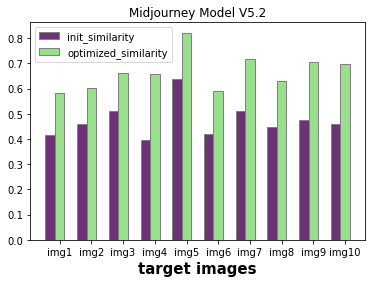

Average initial similarity for Midjourney Model V5.2: 0.47294514924287795
Average optimized similarity for Midjourney Model V5.2: 0.6662062586843968
Average similarity increase for Midjourney Model V5.2: 0.1932611094415188


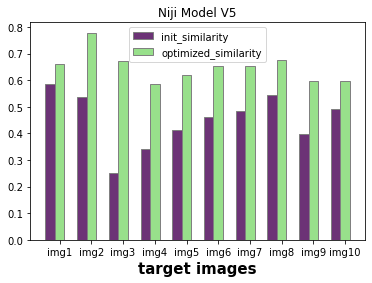

Average initial similarity for Niji Model V5: 0.4507384043186903
Average optimized similarity for Niji Model V5: 0.6494360038638115
Average similarity increase for Niji Model V5: 0.19869759954512123


In [13]:
most_similar_prompt_mat_mid, most_similar_prompt_mat_niji, most_similarity_mat_mid, most_similarity_mat_niji = analyze_similarity(mutate_rate = 'medium')

Total Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Analysis for super low mutate rate


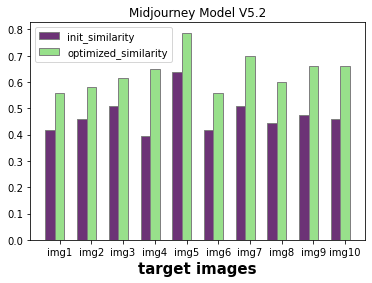

Average initial similarity for Midjourney Model V5.2: 0.47294514924287795
Average optimized similarity for Midjourney Model V5.2: 0.6372504071891307
Average similarity increase for Midjourney Model V5.2: 0.16430525794625278


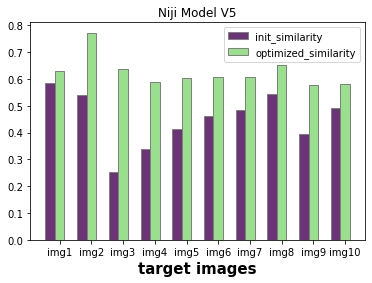

Average initial similarity for Niji Model V5: 0.4507384043186903
Average optimized similarity for Niji Model V5: 0.6257925708591938
Average similarity increase for Niji Model V5: 0.17505416654050354


In [43]:
most_similar_prompt_mat_mid_l, most_similar_prompt_mat_niji_l, most_similarity_mat_mid_l, most_similarity_mat_niji_l = analyze_similarity(mutate_rate = 'super low')

Total Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Analysis for super high mutate rate


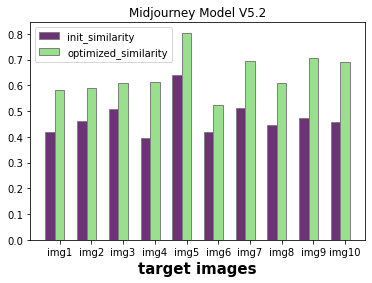

Average initial similarity for Midjourney Model V5.2: 0.47294514924287795
Average optimized similarity for Midjourney Model V5.2: 0.6420614056289196
Average similarity increase for Midjourney Model V5.2: 0.1691162563860416


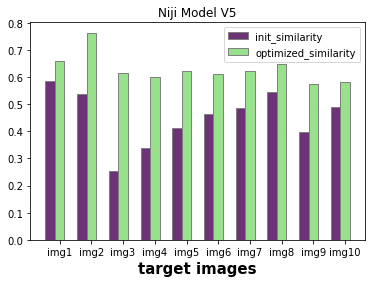

Average initial similarity for Niji Model V5: 0.4507384043186903
Average optimized similarity for Niji Model V5: 0.6302314487099648
Average similarity increase for Niji Model V5: 0.17949304439127456


In [44]:
most_similar_prompt_mat_mid_h, most_similar_prompt_mat_niji_h, most_similarity_mat_mid_h, most_similarity_mat_niji_h = analyze_similarity(mutate_rate = 'super high')